## Example spectra

Here, we show generating an example synthetic spectra, calculating the scores, etc.

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Project specific imports
import QSOtools as QT

In [3]:
# Set some preferences for plt...

In [4]:
workdir = './'

What kind of spectra are available in SDSS?

In [5]:
SDSScat = pd.read_csv(workdir+'datfiles/AllQSOspec_zgt2p1.csv')
SDSScat.head()

,specObjID,ra,dec,z,plate,mjd,fiberid,urlfits
0,300710684738480128,147.17010,0.539087,2.243463,267,51608,347,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
1,302891571118893056,150.98397,-0.994577,2.110910,269,51910,89,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
2,302973209857255424,150.69524,0.351117,2.167938,269,51910,386,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
3,305160412909824000,154.62245,-0.141852,2.137572,271,51883,151,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
4,305284657723762688,155.53053,0.800136,2.107791,271,51883,603,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...


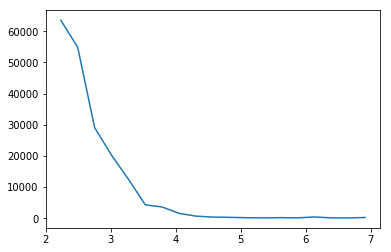

In [6]:
zbins = np.linspace(SDSScat['z'].min(),SDSScat['z'].max(),20)
zmids = 0.5*(zbins[:-1]+zbins[1:])

hist,_ = np.histogram(SDSScat['z'],zbins)
plt.plot(zmids,hist)
plt.show()

Define some things for our example spectra.

In [45]:
Lya = QT.Lya # This is already defined in QSOtools.
z_em = 3.0
DLA_definition = 20.3 # What is the column density of a DLA?
min_column_density = 17.0
v_min = -25000.0
v_max = 3000.0

In [46]:
# We want a spectra with at lease one QSO!
QSO_present = 0
attempts = 0

while QSO_present == 0:
    attempts = attempts+1
    spec_tuple = QT.generate_spectrum(z_em,v_min=v_min,v_max=v_max)
    observed_wv,observed_fl,observed_sig,absorber_CDs,absorber_zs = spec_tuple
    
    if len(absorber_CDs[ absorber_CDs > min_column_density ]) >3:
        QSO_present = 1 # So we can quit the loop if we've found a DLA!
print('Generated a DLA after %i attempts' %attempts)

Generated a DLA after 301 attempts


In [47]:
print('The absorbers with large column densities are (descending):')
with np.printoptions(precision=3, suppress=True):
    print(absorber_CDs)

The absorbers with large column densities are (descending):
[19.915 17.403 17.101 17.051]


We're really only intrested in the bits blueward of the Ly$\alpha$ emission.

In [48]:
prox_wv_max = (1.0 + z_em)*(1.0 + v_max/QT.c)*QT.Lya
prox_wv_min = (1.0 + z_em)*(1.0 + v_min/QT.c)*QT.Lya
prox_mask = (prox_wv_min < observed_wv) & (observed_wv < prox_wv_max)

wv  = observed_wv[prox_mask]
fl  = observed_fl[prox_mask]
sig = observed_sig[prox_mask]


We want to estimate the continuum.

In [49]:
cont = QT.get_continuum(z_em,wv,fl,sig,kind='smooth')

c_fl = fl/cont
c_sig = sig/cont


In [50]:
# We can access the true continnum -- the restframe QSO template:
true_cont_wv = QT.high_resolution_wv*(1.0+z_em)
true_cont_fl = QT.high_resolution_fl

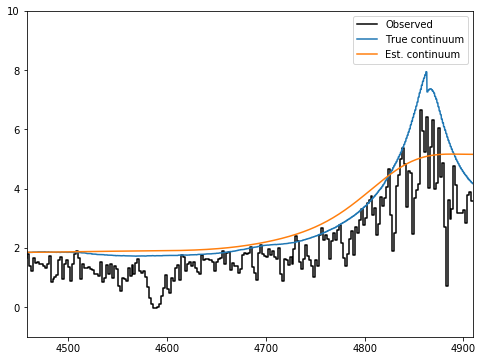

In [51]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(wv,fl,'k',drawstyle='steps',label='Observed')
ax.plot(true_cont_wv,true_cont_fl,label='True continuum')
ax.plot(wv,cont,label='Est. continuum')
ax.legend()

ax.set_xlim(wv.min(),wv.max())
ax.set_ylim(-1,10)

plt.show()

Now we have the continuum, we can estimate the scores.

How many pixels do we want to calculate the score over? A DLA has width of 3.5$\unicode{x212B}$ in restframe. So, at z=3.0, DLA will have width $3.5\times(1.0+z_{em})=14.0\unicode{x212B}$. SDSS has resolution 2.0$\unicode{x212B}$, so this is $7$ pixels.

In [52]:
Npix = int(QT.restframe_window*(1.0+z_em)/QT.SDSS_resolution)

In [53]:
score_wv,score_vals = QT.evaluate_scores(wv,c_fl,c_sig,Npix)

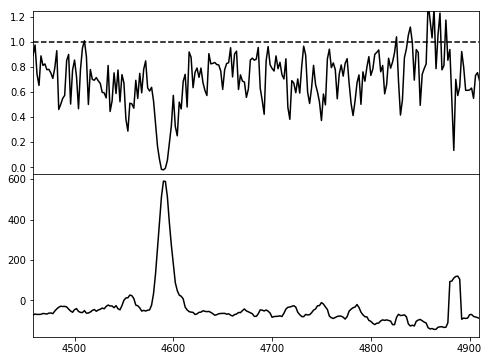

In [54]:
# Set up the axes...
gs = plt.GridSpec(2,1)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(gs[:1,:])
ax2 = fig.add_subplot(gs[1:,:])

ax1.set_xlim(wv.min(),wv.max())
ax1.set_xticks([])

ax2.set_xlim(wv.min(),wv.max())
ax1.set_ylim(-0.05,1.25)

fig.subplots_adjust(hspace=0)

ax1.plot(wv,c_fl,'k')
ax1.plot(wv,c_fl/c_fl,'k--')
ax2.plot(score_wv,score_vals,'k')
plt.show()

Now we look for features in the scores...

In [55]:
feature_widths, feature_zs = QT.extract_features(z_em,score_wv,score_vals,threshold=20)

Match the features to the true absorbers -- currently by matching the largest absorber to the widest feature. Would also be nice to incude z_est - z_true comparison, but unsure of the best way to do this? Woudl the peak score tell us anything?

In [71]:
this_QSO = QT.match_features(z_em,absorber_CDs,absorber_zs,feature_widths,feature_zs)

In [72]:
cols = 'z_em absorber_CD absorber_z feature_width feature_z'.split()
matches_df = pd.DataFrame(this_QSO,columns=cols)
matches_df.head(n=20)

,z_em,absorber_CD,absorber_z,feature_width,feature_z
0,3.0,19.915299,2.775578,3.75,2.778986
1,3.0,17.402736,2.744774,1.50,3.018360
2,3.0,17.101229,2.776469,-1.00,-1.000000
3,3.0,17.050978,3.016739,-1.00,-1.000000


Put them together!

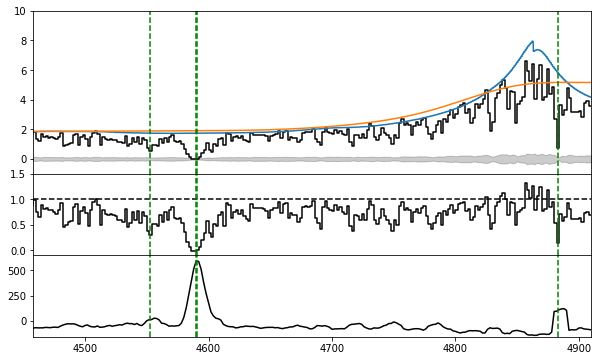

In [75]:
gs = plt.GridSpec(4,1)
fig = plt.figure(figsize=(10,6))
ax1,ax2,ax3 = fig.add_subplot(gs[:2,:]),fig.add_subplot(gs[2:3,:]),fig.add_subplot(gs[3:,:])

ax1.plot(wv,fl,'k',drawstyle='steps')
ax1.fill_between(wv,-sig,sig,color='k',alpha=0.2)
ax1.plot(true_cont_wv,true_cont_fl,label='True continuum')
ax1.plot(wv,cont,label='Est. continuum')

ax2.plot(wv,c_fl,'k',drawstyle='steps')
ax2.plot(wv,c_fl/c_fl,'k--')

ax3.plot(score_wv,score_vals,'k')

yls,yus = [-1,-0.1,1.1*score_vals.min()],[10,1.5,1.1*score_vals.max()]

for ax,yl,yu in zip([ax1,ax2,ax3],yls,yus):
    ax.set_xlim(wv.min(),wv.max())
    ax.set_ylim(yl,yu)
    for row in matches_df.itertuples():
        ax.axvline((1.0+row.absorber_z)*QT.Lya,color='g',ls='--')
    


fig.subplots_adjust(hspace=0)
ax1.set_xticks([]),ax2.set_xticks([])
plt.show()